## PROJECT - Build your own recommendation system for products on an e-commerce website like Amazon.com

## Import all required libaries

In [1]:
import os
import pandas as pd
import numpy as np

#import tensorflow as tf
#import tensorflow.keras as ks

import matplotlib.pyplot as plt
import seaborn as sns

!pip install scikit-surprise

from surprise import KNNWithMeans
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import Reader 
from surprise.model_selection import LeaveOneOut
from collections import defaultdict

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

## STEP 1 - Read and explore the given dataset. ( Rename column/add headers, plot histograms, find data characteristics)

In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!pwd
%cd /content/gdrive/My\ Drive/Colab\ Notebooks/
!pwd

rate_elec = pd.read_csv("ratings_Electronics.csv", sep=',', names=["userid", "productid", "ratings", "timestamp"])
type(rate_elec)

/content
/content/gdrive/My Drive/Colab Notebooks
/content/gdrive/My Drive/Colab Notebooks


pandas.core.frame.DataFrame

In [4]:
print(rate_elec.head(5))
rate_elec.shape
rate_elec = rate_elec.drop(columns = ['timestamp'])


           userid   productid  ratings   timestamp
0   AKM1MP6P0OYPR  0132793040      5.0  1365811200
1  A2CX7LUOHB2NDG  0321732944      5.0  1341100800
2  A2NWSAGRHCP8N5  0439886341      1.0  1367193600
3  A2WNBOD3WNDNKT  0439886341      3.0  1374451200
4  A1GI0U4ZRJA8WN  0439886341      1.0  1334707200


In [5]:
rate_elec.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ratings,7824482.0,4.012337,1.38091,1.0,3.0,5.0,5.0,5.0


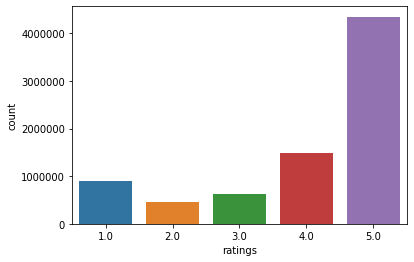

In [6]:
sns.countplot(rate_elec['ratings'])

In [7]:
#EDA for the dataset.

# Building a product based dataset which has first n (4000 etc) products 

rate_elec_prod = pd.DataFrame(rate_elec.groupby('productid')['ratings'].count()) #.sort_values(ascending = False))
rate_elec_prod = rate_elec_prod.head(4000)
#print(rate_elec_prod)

rate_elec_top50prod = pd.merge(rate_elec, rate_elec_prod, on = 'productid')
# changing cols with rename() 
rate_elec_top50prod = rate_elec_top50prod.rename(columns = {"ratings_x": "ratings", "ratings_y":"ratings_count"}) 
rate_elec_top50prod_cnt = rate_elec_top50prod.count()
print('Total Count of random 4000 products are ' , rate_elec_top50prod_cnt)

# Building a user based dataset which has all the products from users who have given 10 no ofratings.

rate_elec_user = pd.DataFrame(rate_elec.groupby('userid')['ratings'].count().sort_values(ascending = False))
#print(rate_elec_user)
rate_elec_topuser = rate_elec_user[rate_elec_user['ratings']>=75]
rate_elec_topuser_cnt = rate_elec_topuser.count()
print('Total Count of TOP USERs ratings are ' , rate_elec_topuser_cnt)

rate_elec_topratingusers = pd.merge(rate_elec, rate_elec_topuser, on = 'userid')
rate_elec_topratingusers = rate_elec_topratingusers.rename(columns = {"ratings_x": "ratings", "ratings_y":"ratings_count"}) 
rate_elec_topratingusers_cnt = rate_elec_topratingusers.count()
print(rate_elec_topratingusers_cnt)

#rate_elec_more = pd.DataFrame(rate_elec.groupby('userid')['productid'].count()>50)            
#rate_elec_more = rate_elec_more['productid'] == True


Total Count of random 4000 products are  userid           56022
productid        56022
ratings          56022
ratings_count    56022
dtype: int64
Total Count of TOP USERs ratings are  ratings    582
dtype: int64
userid           69052
productid        69052
ratings          69052
ratings_count    69052
dtype: int64


(582, 1)
            ratings
productid          
0132793040        1
0321732944        1
0439886341        3
0511189877        6
0528881469       27
0558835155        1
059400232X        3
0594012015        8
0594017343        1
0594017580        1


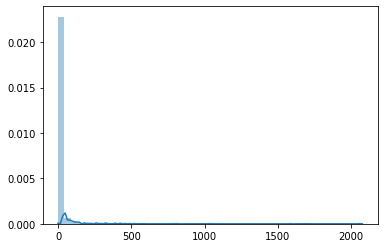

In [8]:
print(rate_elec_topuser.shape)
rate_elec_prod.info
sns.distplot(rate_elec_prod, hist = True)
print(rate_elec_prod.head(10))

## STEP 2 -Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only who has given 50 or more number of ratings )

In [9]:
unique_users_proddataset = rate_elec_top50prod['userid'].nunique()
unique_products_proddataset =  rate_elec_top50prod['productid'].nunique()
print('The no of unique users in prod dataset are ' , unique_users_proddataset)
print('The no of unique products in prod dataset are ' , unique_products_proddataset)

The no of unique users in prod dataset are  51796
The no of unique products in prod dataset are  4000


In [10]:
unique_users_usersdataset = rate_elec_topratingusers['userid'].nunique()
unique_products_usersdataset =  rate_elec_topratingusers['productid'].nunique()
print('The no of unique users in User dataset are ' , unique_users_usersdataset)
print('The no of unique products in User dataset are ' , unique_products_usersdataset)

The no of unique users in User dataset are  582
The no of unique products in User dataset are  31053


## STEP 3 : Build Popularity Recommender model.

In [0]:

rate_elec_count = pd.DataFrame(rate_elec.groupby('productid')['ratings'].mean().sort_values(ascending = False))

In [0]:
rate_elec_count['rating_counts'] = pd.DataFrame(rate_elec.groupby('productid')['ratings'].count())

In [0]:
#rate_elec_count.head(10)

In [0]:
def weighted_rating(rating_mean_count, min_votes, mean_rating_dataset):
    weighted_rating = list()
    V = rating_mean_count.rating_counts.values
    R = rating_mean_count.ratings.values
    for v, r in zip(V, R):
        if v < 5:
            weighted_rating.append(0)
        else:
            weighted_rating.append((v/(v+min_votes))*r + (min_votes/(v+min_votes))*mean_rating_dataset)
    return(weighted_rating)

In [0]:
min_votes = 5
mean_rating_dataset = np.mean(rate_elec_count.ratings.values)


In [0]:
rate_elec_count['weighted_rating'] = weighted_rating(rate_elec_count, min_votes, mean_rating_dataset)

In [17]:
rate_elec_count.weighted_rating.sort_values(ascending = False).head(10)

productid
B00CG70K78    4.927473
B00GMRCAC6    4.924211
B008VGCT9K    4.916802
B000053HC5    4.914904
B008I6RVZU    4.902301
B0043ZLFXE    4.899458
B008I64AQ8    4.888970
B0033PRWSW    4.888899
B007SZ0E1K    4.884248
B004I763AW    4.883823
Name: weighted_rating, dtype: float64

In [18]:
print("The above is the top Product ID's which has higher Weighted rating, which can be recommended as part of Popular products")

The above is the top Product ID's which has higher Weighted rating, which can be recommended as part of Popular products


## STEP 4. Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio)

In [19]:
rate_elec.count()

userid       7824482
productid    7824482
ratings      7824482
dtype: int64

In [0]:
reader = Reader()
rate_elec_top50prod = Dataset.load_from_df(rate_elec_top50prod[['userid','productid','ratings']],reader)
rate_elec_topratingusers = Dataset.load_from_df(rate_elec_topratingusers[['userid','productid','ratings']],reader)

In [0]:
train_prodset, test_prodset = train_test_split(rate_elec_top50prod, test_size=.30)
train_userset, test_userset = train_test_split(rate_elec_topratingusers, test_size=.30)

## STEP 5 : Build Collaborative Filtering model.

#### Predict recommendation using KNN MEANS for PRODUCT-PRODUCT collabrative filtering

In [22]:
algo_product = KNNWithMeans(k=0, sim_options={'name': 'pearson_baseline', 'user_based': False})
algo_product.fit(train_prodset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [0]:
test_prod_pred = algo_product.test(test_prodset)

In [24]:
print("Product-based Model : Test Set")
accuracy.rmse(test_prod_pred, verbose=True)

Product-based Model : Test Set
RMSE: 1.3486


1.3485855755334908

#### Predict recommendation using KNN MEANS for USER-USER collabrative filtering

In [25]:
algo_user = KNNWithMeans(k=10, sim_options={'name': 'pearson_baseline', 'user_based': True})
algo_user.fit(train_userset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [0]:
test_user_pred = algo_user.test(test_userset)

In [27]:
print("User-based Model : Test Set")
accuracy.rmse(test_user_pred, verbose=True)

User-based Model : Test Set
RMSE: 1.0454


1.0453952392829804

#### Predict recommendation using SVD for USER-USER collabrative filtering

In [28]:
from surprise.model_selection import cross_validate
algo_svd = SVD(n_factors = 10)
cross_validate(algo_svd, rate_elec_topratingusers, measures=['RMSE', 'MAE'], cv=15, verbose=True)
algo_svd.fit(train_userset)

Evaluating RMSE, MAE of algorithm SVD on 15 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Fold 11 Fold 12 Fold 13 Fold 14 Fold 15 Mean    Std     
RMSE (testset)    0.9452  0.9529  0.9596  0.9617  0.9627  0.9652  0.9596  0.9413  0.9375  0.9518  0.9432  0.9892  0.9662  0.9826  0.9788  0.9598  0.0148  
MAE (testset)     0.7077  0.7097  0.7046  0.7110  0.7184  0.7144  0.7113  0.6983  0.6983  0.7073  0.7077  0.7391  0.7232  0.7264  0.7295  0.7138  0.0112  
Fit time          1.50    1.52    1.53    1.53    1.57    1.54    1.56    1.55    1.58    1.53    1.53    1.54    1.55    1.54    1.54    1.54    0.02    
Test time         0.04    0.03    0.04    0.03    0.04    0.04    0.04    0.04    0.04    0.03    0.19    0.03    0.03    0.03    0.04    0.05    0.04    


In [0]:
test_user_pred_svd = algo_svd.test(test_userset)

In [30]:
# get RMSE
print("SVD Model : User Test Set")
accuracy.rmse(test_user_pred_svd, verbose=True)

SVD Model : User Test Set
RMSE: 0.9721


0.9720680088568955

In [31]:
algo_svd = SVD(n_factors = 5)
algo_svd.fit(train_prodset)

In [0]:
test_prod_pred_svd = algo_svd.test(test_prodset)

In [33]:
# get RMSE
print("SVD Model : Prod Test Set")
accuracy.rmse(test_prod_pred_svd, verbose=True)

SVD Model : Prod Test Set
RMSE: 1.2814


1.2813663124588768

#### Using GridSearchCV



In [34]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(rate_elec_topratingusers)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9742010857812501
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


In [35]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(rate_elec_top50prod)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.2944470942612287
{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}


### STEP 7 -> Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products.

In [0]:
def get_top_n(predictions, n=5):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [37]:
print(test_user_pred_svd)

Output hidden; open in https://colab.research.google.com to view.

In [38]:
print("TOP 5 predictions based on user-user collaborative filtering")
get_top_n(test_user_pred_svd,5)

TOP 5 predictions based on user-user collaborative filtering


defaultdict(list,
            {'A100UD67AHFODS': [('B00F0DD0I6', 4.860396319305598),
              ('B003O8682Y', 4.589028575972013),
              ('B0077YTFPS', 4.541586894902513),
              ('B001A5FH9S', 4.53472993270837),
              ('B0001D3K8A', 4.478877134542509)],
             'A100WO06OQR8BQ': [('B0002LEMWE', 3.9455756594028757),
              ('B00HSQAIQU', 3.9452073041218405),
              ('B002VPE1X4', 3.911868095081394),
              ('B005CLMJLU', 3.8745832756819043),
              ('B001AW8W7A', 3.863554704220132)],
             'A10NMELR4KX0J6': [('B005ES0YYA', 4.4262111771304635),
              ('B005FYNSPK', 4.3843013967031546),
              ('B002AJMHMI', 4.376125268406214),
              ('B002MMY4WY', 4.335146141163099),
              ('B007SZ0EOW', 4.2471239925076745)],
             'A10O7THJ2O20AG': [('B001XURP7W', 5),
              ('B001ID829O', 5),
              ('B002BH3Z8E', 5),
              ('B003FWEQDM', 5),
              ('B00017LSPI', 5)],
 

In [39]:
print("TOP 5 predictions based on product-product collaborative filtering")
get_top_n(test_prod_pred_svd,5)

TOP 5 predictions based on product-product collaborative filtering


defaultdict(list,
            {'A1FM50L5NH0OWE': [('B00004TBLW', 4.3397160890255355)],
             'A3HSPJ8OF5HX89': [('B00001P4XA', 3.863437570539762)],
             'A3J8V5GJ1IRGC3': [('9983891212', 4.499383066549375)],
             'AUWWQX0VM9PS6': [('B00001OPJV', 4.035104957229481)],
             'A2DC2WTRORR6PC': [('9985511425', 4.3735401161302185)],
             'A6F6QFUX9B29X': [('B00004RKEX', 2.8191340791409436)],
             'A3EQ61ES6HQ090': [('B00003006Z', 4.0125477291459015),
              ('B00004SB92', 3.9375037050532504)],
             'A2UQPKKR9KK2F3': [('B00004T8R2', 4.204125410162842)],
             'A31F3SHLCT1617': [('B00004TS2Y', 4.031620553359684)],
             'A3KWLKNLNU1Z23': [('B00004THD8', 4.329987123929559)],
             'A3TUZOJZM9008Y': [('B00004TDN1', 4.172736325557642),
              ('B00000J4M9', 4.118165713776296)],
             'A15AEE8R6CXDFI': [('B00004TDLD', 4.811204586189111)],
             'A2WXJG6CCL5A7B': [('B00004T8R2', 4.204125410162842)

### STEP 8 - Summarise your insights.

DATA INSIGHTS - 1. 5 Star ratings are high and constitute more than 50% of the total ratings.


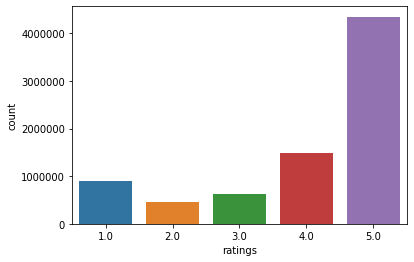

In [40]:
sns.countplot(rate_elec['ratings'])
print("DATA INSIGHTS - 1. 5 Star ratings are high and constitute more than 50% of the total ratings.")

In [51]:
print("PREDICTION INSIGHTS - 2.GREY SHEEP Identification- .")

PREDICTION INSIGHTS - 2.GREY SHEEP Identification- .


In [0]:
#LOOCV = LeaveOneOut(n_splits=1, random_state=1)
#algo = SVD(n_factors = 10)
#for trainSet, testSet in LOOCV.split(rate_elec_topratingusers):
    # Train model without left-out ratings
#    algo.fit(trainSet)
    # Predicts ratings for left-out ratings only
#    leftOutPredictions = algo.test(testSet)
    # Build predictions for all ratings not in the training set
#    bigTestSet = trainSet.build_anti_testset()
#    allPredictions = algo.test(bigTestSet)
    # Compute top 10 recs for each user
#   topNPredicted = get_top_n(allPredictions, n=10)



In [52]:
print("PREDICTION APPROACH -> 2 datasets were created.")
print(" The First one (NAME - rate_elec_top50prod) was created by taking 4000 rows of the aggregation of product reviews. ")
print("The total reviews in the product dataset is " , rate_elec_top50prod_cnt)
print('The no of unique users in prod dataset are ' , unique_users_proddataset)
print('The no of unique products in prod dataset are ' , unique_products_proddataset)

print(" The second dataset (NAME - rate_elec_topratingusers) was created by taking all rows of the aggregation of users who have reviewed more than 75 products.")
print("The total reviews in the user dataset is " , rate_elec_topratingusers_cnt)
print('The no of unique users in User dataset are ' , unique_users_usersdataset)
print('The no of unique products in User dataset are ' , unique_products_usersdataset)


PREDICTION APPROACH -> 2 datasets were created.
 The First one (NAME - rate_elec_top50prod) was created by taking 4000 rows of the aggregation of product reviews. 
The total reviews in the product dataset is  userid           56022
productid        56022
ratings          56022
ratings_count    56022
dtype: int64
The no of unique users in prod dataset are  51796
The no of unique products in prod dataset are  4000
 The second dataset (NAME - rate_elec_topratingusers) was created by taking all rows of the aggregation of users who have reviewed more than 75 products.
The total reviews in the user dataset is  userid           69052
productid        69052
ratings          69052
ratings_count    69052
dtype: int64
The no of unique users in User dataset are  582
The no of unique products in User dataset are  31053


In [49]:
print("ALGORITHM - KNNMeans algo and SVD algo from SURPRISE package was used for prediction.")
print("MODEL SELECTION - GridSearch CV and CrossValidate was used for getting the testing the model and its parameters.")
print("The pearson_baseline similarity measure was used as it was prescribed as the best practice among measures.")

ALGORITHM - KNNMeans algo and SVD algo from SURPRISE package was used for prediction.
MODEL SELECTION - GridSearch CV and CrossValidate was used for getting the testing the model and its parameters.
The pearson_baseline similarity measure was used as it was prescribed as the best practice among measures.


In [50]:
print("MODEL INSIGHTS - RMSE Scores")
print("The best RMSE score was arrived with SVD algorithm using Cross Validation.")
print("Best RMSE Score for User dataset - 0.9721")
print("Best RMSE Score for Product dataset - 1.2814")


MODEL INSIGHTS - RMSE Scores
The best RMSE score was arrived with SVD algorithm using Cross Validation.
Best RMSE Score for User dataset - 0.9721
Best RMSE Score for Product dataset - 1.2814


In [46]:
print("PREDICTION INSIGHTS - HIT RATE Metrics")

PREDICTION INSIGHTS - HIT RATE Metrics
